# Customer Segmentation Analysis

## Data Preparation

In [1]:
# Importing libraries

import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore


In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# Importing datasets

train_df = pd.read_csv(r"D:\Data Analysis\Jupyter Notebook\Customer Segmentation\Train.csv")
test_df = pd.read_csv(r"D:\Data Analysis\Jupyter Notebook\Customer Segmentation\Test.csv")


In [4]:
# Shape of train dataframe

train_df.shape

(8068, 11)

In [5]:
# Numerical summary of train dataframe

train_df.describe(include='number')

,ID,Age,Work_Experience,Family_Size
count,8068.00,8068.00,7239.00,7733.00
mean,463479.21,43.47,2.64,2.85
std,2595.38,16.71,3.41,1.53
min,458982.00,18.00,0.00,1.00
25%,461240.75,30.00,0.00,2.00
50%,463472.50,40.00,1.00,3.00
75%,465744.25,53.00,4.00,4.00
max,467974.00,89.00,14.00,9.00


In [6]:
# Categorical summary of train dataframe

train_df.describe(exclude='number')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [8]:
# Percentage of null values in each column

train_df.isnull().sum() / train_df.shape[0] * 100

ID                 0.00
Gender             0.00
Ever_Married       1.74
Age                0.00
Graduated          0.97
Profession         1.54
Work_Experience   10.28
Spending_Score     0.00
Family_Size        4.15
Var_1              0.94
Segmentation       0.00
dtype: float64

<Axes: ylabel='Frequency'>

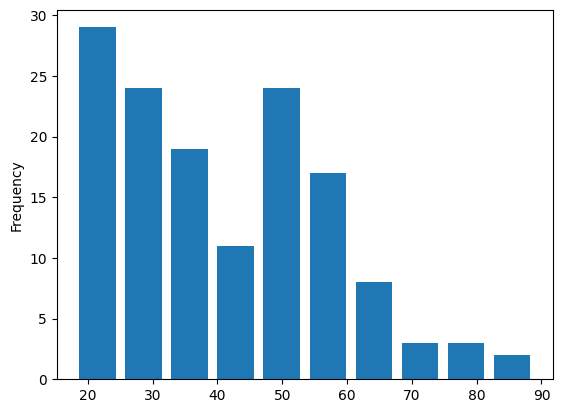

In [9]:
# Distribution of Ages of customers with 'Ever_Married' == null

train_df.loc[pd.isna(train_df['Ever_Married']), 'Age'].plot(kind='hist', rwidth=0.8)

Looking at the distribution of Ages of customers in which the *Ever_Married* column is null, we observe that the majority of the ages lie within the 20s to mid 30s range. From this, we will speculate that these individuals more than likely have never been married before and will replace these empty values with *'No'*.

In [10]:
train_df['Ever_Married'] = train_df['Ever_Married'].fillna('No')

<Axes: ylabel='count'>

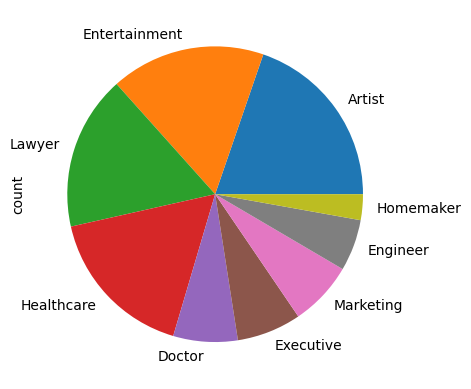

In [11]:
train_df.loc[pd.isna(train_df['Graduated']), 'Profession'].value_counts().plot(kind='pie')

Looking at the distribution of Professions for customers with *Graduated* column as null, we will assume that customers who are Homemakers, Artists, and Entertainers have not graduated from an accredited post-secondary institution, whilst customers in the other fields have. We argue this, as to become a Lawyer or Doctor, typically requires multiple years at a post-secondary institution followed by additional studies. Whereas, an artist may not necessarily have attended a post-secondary institution.

In [12]:
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Homemaker'), 'Graduated'] = 'No'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Artist'), 'Graduated'] = 'No'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Entertainment'), 'Graduated'] = 'No'

train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Lawyer'), 'Graduated'] = 'Yes'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Engineer'), 'Graduated'] = 'Yes'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Marketing'), 'Graduated'] = 'Yes'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Executive'), 'Graduated'] = 'Yes'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Doctor'), 'Graduated'] = 'Yes'
train_df.loc[(pd.isna(train_df['Graduated'])) & (train_df['Profession'] == 'Healthcare'), 'Graduated'] = 'Yes'

# If Graduated and Profession are both null, we will fill the null values with 'No' 

train_df.loc[(pd.isna(train_df['Graduated'])) & (pd.isna(train_df['Profession'])), 'Graduated'] = 'No'

For all entries in which the *Profession* column is null, we will fill in the missin value with 'Unemployed'. Note that the term unemployed could mean unemployed or retired.

In [13]:
train_df['Profession'] = train_df['Profession'].fillna('Unemployed')

In [14]:
# Filling in missing values with 1.0 for Family_Size to represent a single person in the family (the customer themselves)

train_df['Family_Size'] = train_df['Family_Size'].fillna(1.0)

In [15]:
# Filling in missing values for Work_Experience with median value

median_value = train_df['Work_Experience'].median()
train_df['Work_Experience'] = train_df['Work_Experience'].fillna(median_value)

In [16]:
# Dropping ID, Var_1 column

train_df.drop(columns=['ID', 'Var_1'], inplace=True)

In [17]:
# Dropping outliers

# Age
q1, q3 = np.percentile(train_df['Age'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

train_df = train_df[(train_df['Age'] >= lower_bound) & (train_df['Age'] <= upper_bound)]

# Work_Experience
q1, q3 = np.percentile(train_df['Work_Experience'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

train_df = train_df[(train_df['Work_Experience'] >= lower_bound) & (train_df['Work_Experience'] <= upper_bound)]


# Family_Size
q1, q3 = np.percentile(train_df['Family_Size'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

train_df = train_df[(train_df['Family_Size'] >= lower_bound) & (train_df['Family_Size'] <= upper_bound)]

train_df = train_df.reset_index().drop(columns='index')
train_df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,Male,No,22,No,Healthcare,1.00,Low,4.00,D
1,Female,Yes,38,Yes,Engineer,1.00,Average,3.00,A
2,Female,Yes,67,Yes,Engineer,1.00,Low,1.00,B
3,Male,Yes,67,Yes,Lawyer,0.00,High,2.00,B
4,Female,Yes,40,Yes,Entertainment,1.00,High,6.00,A
...,...,...,...,...,...,...,...,...,...
7715,Male,No,22,No,Unemployed,0.00,Low,7.00,D
7716,Male,No,35,No,Executive,3.00,Low,4.00,D
7717,Female,No,33,Yes,Healthcare,1.00,Low,1.00,D
7718,Female,No,27,Yes,Healthcare,1.00,Low,4.00,B


## Data Exploration

### Univariate Analysis

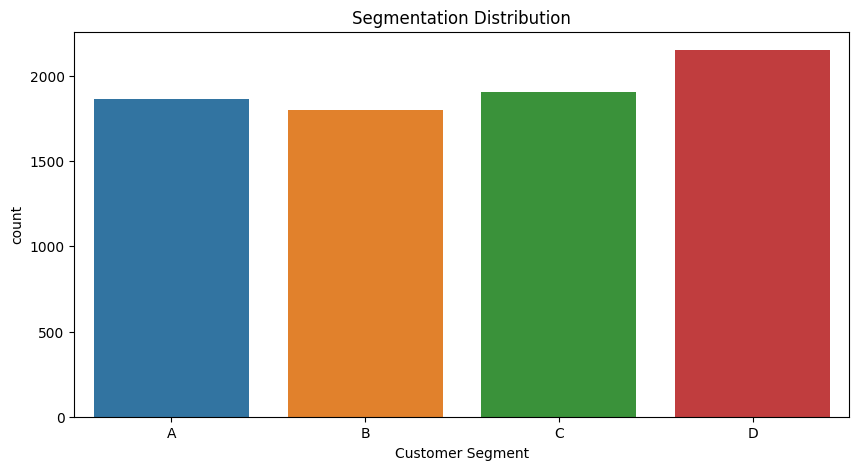

In [18]:
# Distribution of Segmentation to check for class imbalance

plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, 
              x='Segmentation', 
              hue='Segmentation', 
              order=['A', 'B', 'C', 'D'], 
              hue_order=['A', 'B', 'C', 'D'])
plt.title('Segmentation Distribution')
plt.xlabel('Customer Segment')
plt.show()

The graph shows a relatively balanced distribution of customer segmentation.

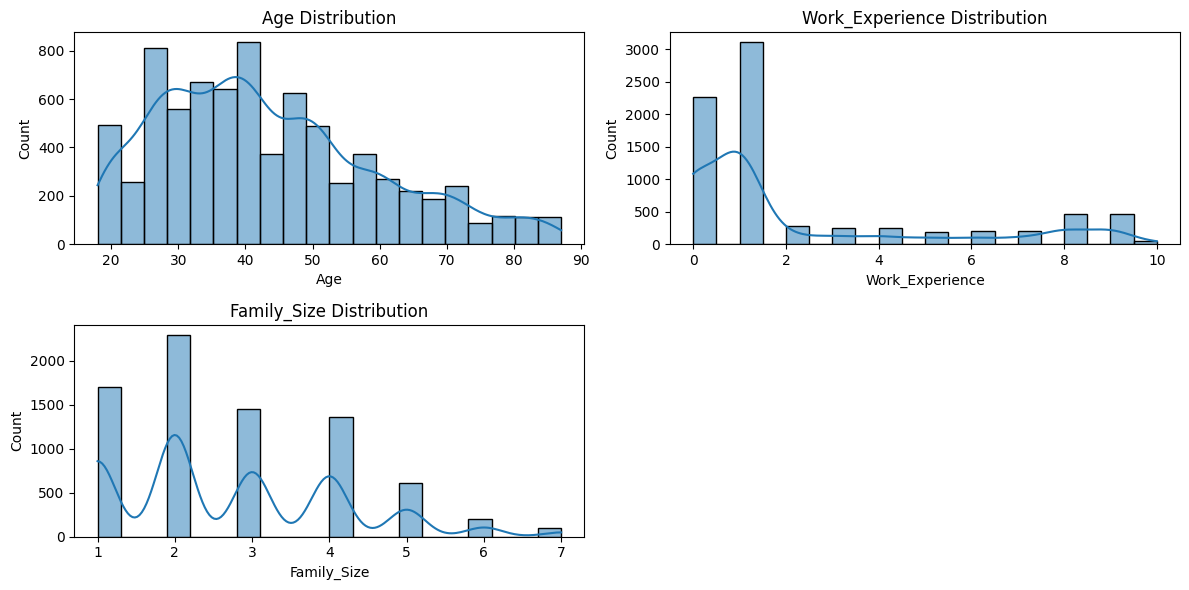

In [19]:
# Numerical Distribution

num_cols = train_df.select_dtypes(include='number').columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
k = 0
for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i, j].axis('off')
            break
        data = train_df[num_cols[k]]
        sns.histplot(data=data, bins=20, kde=True, ax=axes[i,j])
        axes[i,j].set_title(num_cols[k] + ' Distribution')
        axes[i,j].set_xlabel(num_cols[k])        
        k += 1

plt.tight_layout()
plt.show()

**Observations:**

- Customer ages peak at between the mid 20s to early 40s demographic.
- Most customers are recent hires in their field.
- Most customers live in a 2 person household, themselves included.

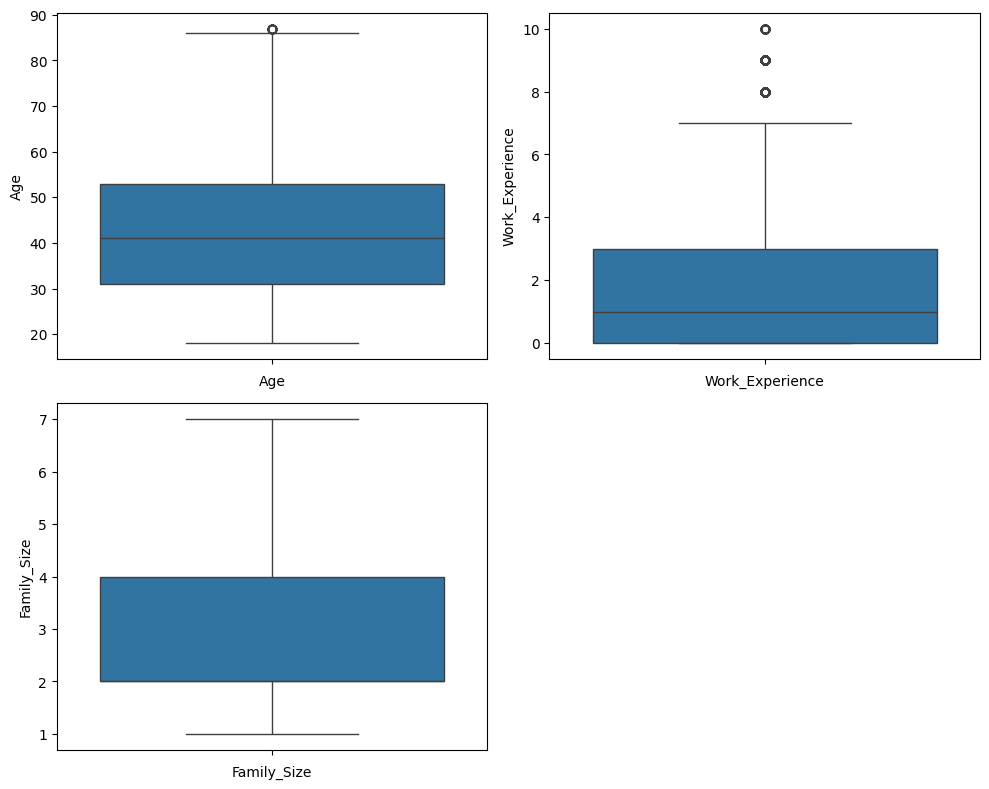

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
k = 0
for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i, j].axis('off')
            break
        data = train_df[num_cols[k]]
        sns.boxplot(data=data, ax=axes[i,j])
        axes[i,j].set_xlabel(num_cols[k])        
        k += 1

plt.tight_layout()
plt.show()

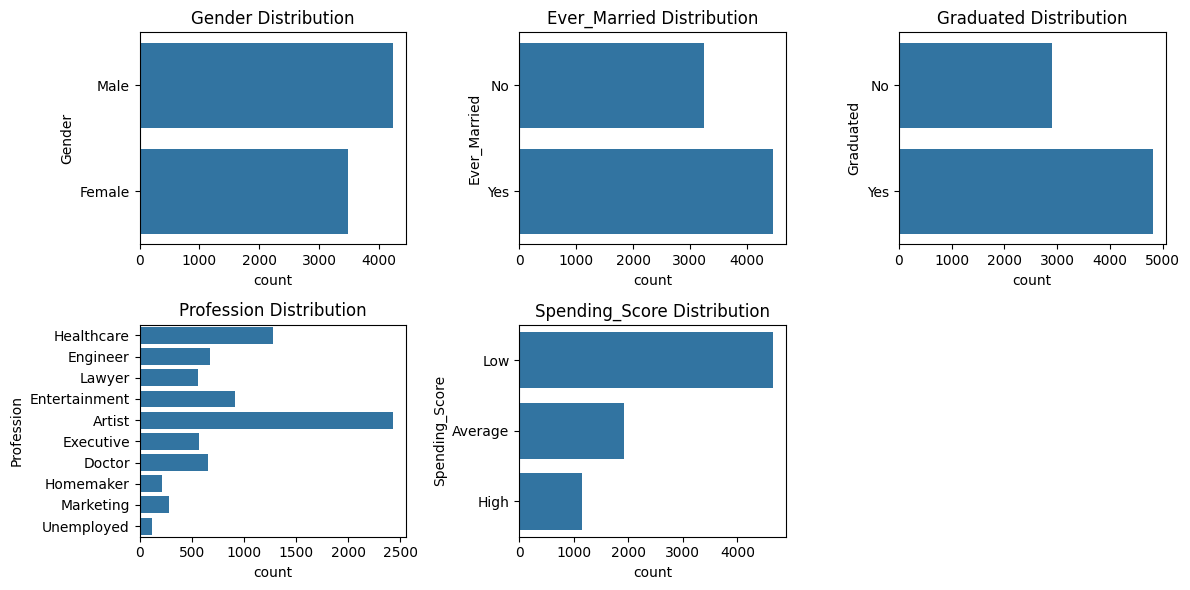

In [21]:
# Categorical Distribution

cat_cols = train_df.select_dtypes(exclude='number').columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
k = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            axes[i, j].axis('off')
            break
        data = train_df[cat_cols[k]]
        sns.countplot(data=data, ax=axes[i,j])
        axes[i,j].set_title(cat_cols[k] + ' Distribution')
        # axes[i,j].set_xlabel(data.name)        
        k += 1

plt.tight_layout()
plt.show()

**Observations:**

- Relatively even ratio of male to female customers, with slightly more male customers than female.
- Most customers are/have been married
- Most customers are graduates from a post-secondary institution.
- There is an overwhelmingly high amount of artists within our customer base.
- Customer spending score tends to be low.

### Bivariate Analysis

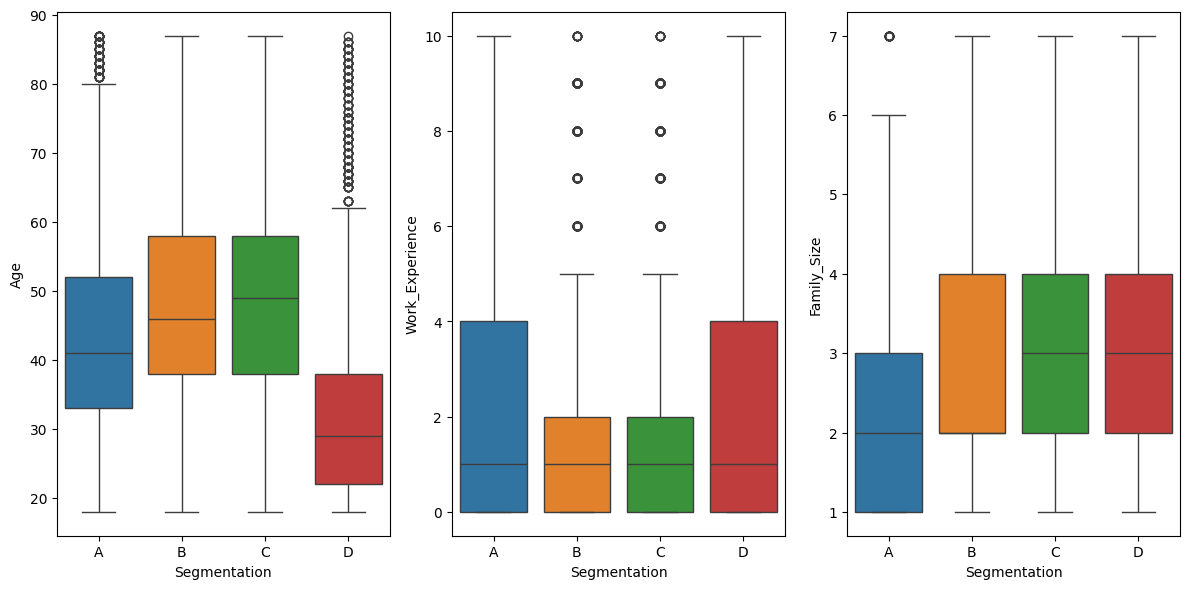

In [22]:
# Examining numerical features against customer segmentation

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
k = 0

for i in range(3):
    sns.boxplot(data=train_df,
                x = 'Segmentation',
                y = num_cols[k],
                hue='Segmentation',
                ax = axes[i],
                order=['A', 'B', 'C', 'D'],
                hue_order=['A', 'B', 'C', 'D'])
    k += 1
    

plt.tight_layout()
plt.show()

**Observations:**

- Customers in Segment D tend to be younger whilst older customers tend to be segments in B or C.
- Customers in Segment A and D have more work experience.
- Customers in Segment A have lower family sizes than customers in other segments.

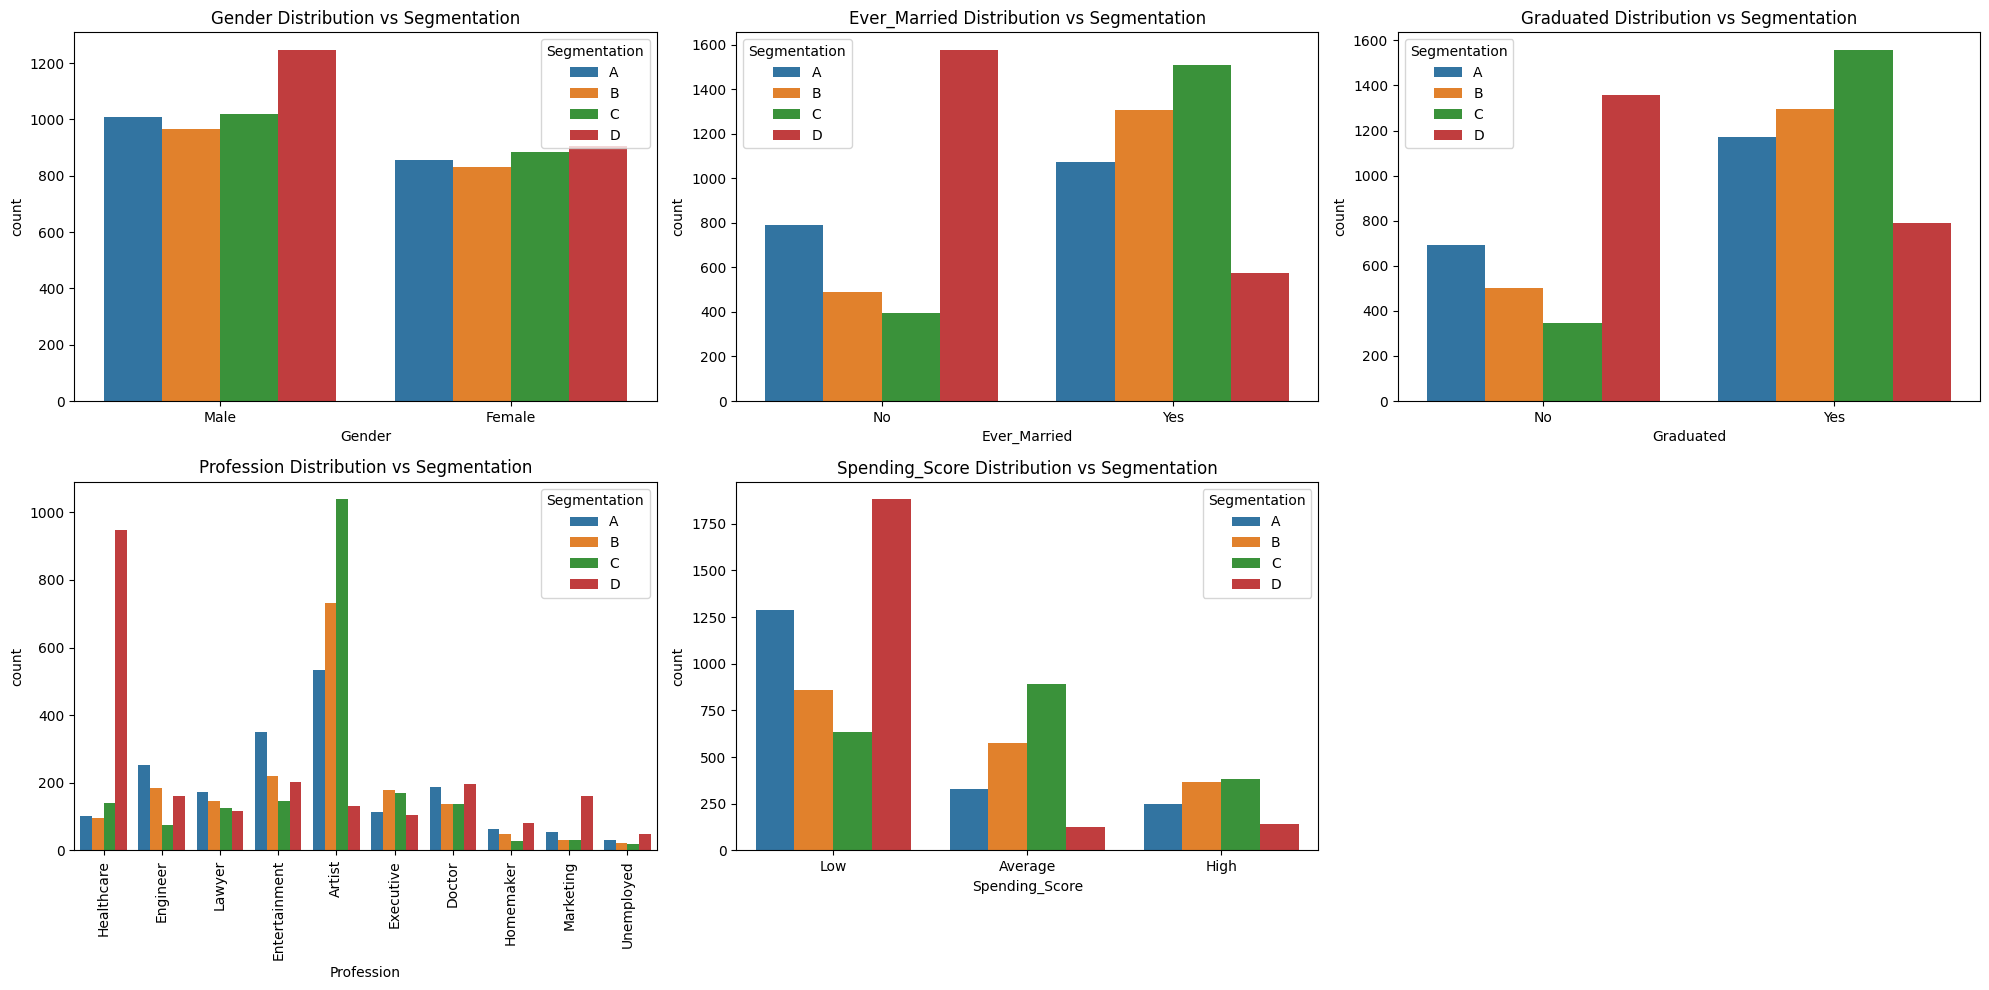

In [23]:
# Examining categorical features against customer segmentation prediction

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
k = 0
data = train_df[cat_cols]

for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            axes[i,j].axis('off')
            break
        sns.countplot(data=data,
                    x = cat_cols[k],
                    ax=axes[i,j],
                    hue='Segmentation',
                    hue_order=['A', 'B', 'C', 'D'])
        axes[i,j].set_title(cat_cols[k] + ' Distribution vs Segmentation')
        k += 1

axes[1, 0].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Observations:**

- Males tends to be in segment D, whilst females are evenly distributed amongst all segments.
- Single customers tend to be segments D with married (or previously married) customers are mainly in segment C
- Customers with a Low spending score are mainly in segment D.
- Customers who have never graduated tend to be in segment D.

### Multivariate Analysis

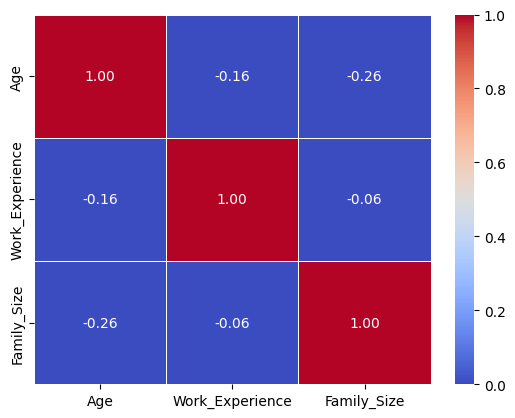

In [24]:
# Correlation

corr = train_df[num_cols].corr()

sns.heatmap(data=corr, vmin=0.0, vmax=1.0, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.show()

From the heatmap above, we see that there is no correlation between any numerical variables

## Data Preprocessing

In [25]:
processed_df = train_df.copy(deep=True)

In [26]:
# Encoding categorical variables

from sklearn.preprocessing import OneHotEncoder # type: ignore

# Encoding Spending_Score

processed_df['Spending_Score'] = pd.Categorical(processed_df['Spending_Score'], categories=['Low', 'Average', 'High'],\
                                                 ordered=True)

processed_df['Spending_Score'] = processed_df['Spending_Score'].cat.codes

# Encoding variables Gender, Ever_Married, Graduated
encoded_cols = pd.get_dummies(processed_df[['Gender', 'Ever_Married', 'Graduated']], drop_first=True)

processed_df = pd.concat([processed_df, encoded_cols], axis=1)

processed_df = processed_df.drop(['Gender', 'Ever_Married', 'Graduated'], axis=1)

# Encoding Profession
one_hot_encoder = OneHotEncoder(sparse_output=False)

profession_encoded = one_hot_encoder.fit_transform(processed_df[['Profession']])

profession_df = pd.DataFrame(profession_encoded, columns=one_hot_encoder.get_feature_names_out(['Profession']))

encoded_df = pd.concat([processed_df, profession_df], axis=1)

encoded_df = encoded_df.drop(columns=['Profession'], axis=1)

# Re-ordering columns
col = encoded_df.pop('Segmentation')

encoded_df.insert(17, 'Segmentation', col)

encoded_df


,Age,Work_Experience,Spending_Score,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unemployed,Segmentation
0,22,1.00,0,4.00,True,False,False,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,D
1,38,1.00,1,3.00,False,True,True,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,A
2,67,1.00,0,1.00,False,True,True,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,B
3,67,0.00,2,2.00,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,B
4,40,1.00,2,6.00,False,True,True,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7715,22,0.00,0,7.00,True,False,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,D
7716,35,3.00,0,4.00,True,False,False,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,D
7717,33,1.00,0,1.00,False,False,True,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,D
7718,27,1.00,0,4.00,False,False,True,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,B


In [27]:
# Standardizing data

from sklearn.preprocessing import StandardScaler # type: ignore

scaler = StandardScaler()
num_cols = encoded_df.select_dtypes(include='number').columns.to_list()

encoded_df[num_cols] = scaler.fit_transform(encoded_df[num_cols])

## Model Selection and Training

In [28]:
# Splitting the dataframe into feature matrix (X) and target vector (y)

from sklearn.model_selection import train_test_split # type: ignore

X = encoded_df.drop(columns='Segmentation')
y = encoded_df['Segmentation']

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.metrics import accuracy_score # type: ignore

model = LogisticRegression(random_state=5, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Logistic Regression model accuracy:', acc*100.0, '%')

Logistic Regression model accuracy: 50.8419689119171 %


### Decision Trees

In [30]:
from sklearn.tree import DecisionTreeClassifier # type: ignore

model = DecisionTreeClassifier(random_state=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Decision Tree model accuracy:', acc*100.0, '%')

Decision Tree model accuracy: 41.70984455958549 %


### CatBoost

In [31]:
from catboost import CatBoostClassifier # type: ignore

model = CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('CatBoost model accuracy:', acc*100.0, '%')

CatBoost model accuracy: 51.42487046632125 %


### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier # type: ignore

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Random Forest model accuracy:', acc*100.0, '%')

Random Forest model accuracy: 46.82642487046632 %


### Support Vector Machines (SVM)

In [33]:
from sklearn.svm import SVC # type: ignore

model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('SVM model accuracy:', acc*100.0, '%')

SVM model accuracy: 48.44559585492228 %


### K-Nearest Neighbours (KNN)

In [34]:
from sklearn.neighbors import KNeighborsClassifier # type: ignore

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('KNN model accuracy:', acc*100.0, '%')

KNN model accuracy: 45.46632124352332 %


## Hyperparameter Tuning

In [35]:
# Importing Grid Search and Randomized Search

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # type: ignore

### Logistic Regression

In [36]:
# Define the model
log_reg = LogisticRegression(max_iter=100)

# Define the hyperparameters to tune
param_grid = {
    'penalty':['l2'],
    'C':[0.01, 0.1, 1, 10, 100],
    'solver':['lbfgs', 'saga']
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_*100.0, '%')

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best score: 50.8256357847569 %


### Decision Tree

In [37]:
# Define the model
decision_tree = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best Parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_*100.0, '%')

Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best score: 51.716232328393794 %


### CatBoost

In [38]:
# Define the model
catboost = CatBoostClassifier(verbose=0)

# Define hyperparameters to tune
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform Random Search
random_search = RandomizedSearchCV(estimator=catboost, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=5)
random_search.fit(X_train, y_train)

# Best parameters and score
print('Best Parameters:', random_search.best_params_)
print('Best Score:', random_search.best_score_*100.0, '%')


Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 4}
Best Score: 54.20976638758959 %


### Random Forest

In [39]:
# Define the model
random_forest = RandomForestClassifier()

# Define hyperparameters to tune
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Perform Random Search
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=5)
random_search.fit(X_train, y_train)

# Best parameters and score
print('Best Parameters:', random_search.best_params_)
print('Best score:', random_search.best_score_*100.0, '%')

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Best score: 53.48104765273902 %


### SVM

In [40]:
# Define model
svm = SVC()

# Define hyperparameters to tune
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
}

# Perform Random Search
random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=5)
random_search.fit(X_train, y_train)

# Best parameters and score
print('Best Parameters:', random_search.best_params_)
print('Best score:', random_search.best_score_*100.0, '%')


Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best score: 52.1372063467107 %


### KNN

In [41]:
# Define the model
knn = KNeighborsClassifier()

# Define the hyperparameters to tune
param_dist = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized search
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist,  n_iter=20, scoring='accuracy', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
print('Best parameters:', random_search.best_params_)
print('Best score:', random_search.best_score_*100.0, '%')

Best parameters: {'weights': 'uniform', 'n_neighbors': 20, 'metric': 'minkowski'}
Best score: 50.5664347575436 %


From our models above, we observe that the CatBoost model withe following parameters:
- *learning_rate* = 0.1
- *l2_leaf_reg* = 5
- *iterations* =  200
- *depth* = 4

Results in the highest accuracy score of ~ 54.21%.

Hence, we will use this model, along with these parameters, to predict segments for new customers in the *test.csv* file.

## Predicting Segments for New Customers

### Preprocessing Data:

We will repeat the same preprocessing steps performed earlier to our train dataset.

In [42]:
# Shape of test dataframe

test_df.shape

(2627, 10)

In [43]:
# Numerical summary of test dataframe

test_df.describe(include='number')

,ID,Age,Work_Experience,Family_Size
count,2627.00,2627.00,2358.00,2514.00
mean,463433.92,43.65,2.55,2.83
std,2618.25,16.97,3.34,1.55
min,458989.00,18.00,0.00,1.00
25%,461162.50,30.00,0.00,2.00
50%,463379.00,41.00,1.00,2.00
75%,465696.00,53.00,4.00,4.00
max,467968.00,89.00,14.00,9.00


In [44]:
# Categorical summary of test dataframe

test_df.describe(exclude='number')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
count,2627,2577,2603,2589,2627,2595
unique,2,2,2,9,3,7
top,Male,Yes,Yes,Artist,Low,Cat_6
freq,1424,1520,1602,802,1616,1672


In [45]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [46]:
# Percentage of null values in each column in test data

test_df.isnull().sum() / test_df.shape[0] * 100.0

ID                 0.00
Gender             0.00
Ever_Married       1.90
Age                0.00
Graduated          0.91
Profession         1.45
Work_Experience   10.24
Spending_Score     0.00
Family_Size        4.30
Var_1              1.22
dtype: float64

### Handling Null Values

In [47]:
# Ever_Married

test_df['Ever_Married'] = test_df['Ever_Married'].fillna('No')


<Axes: ylabel='count'>

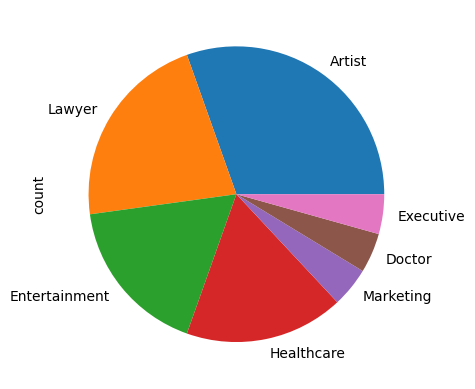

In [48]:
test_df.loc[pd.isna(test_df['Graduated']), 'Profession'].value_counts().plot(kind='pie')

In [49]:
# Graduated

test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Artist'), 'Graduated'] = 'No'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Entertainment'), 'Graduated'] = 'No'

test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Lawyer'), 'Graduated'] = 'Yes'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Engineer'), 'Graduated'] = 'Yes'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Marketing'), 'Graduated'] = 'Yes'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Executive'), 'Graduated'] = 'Yes'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Doctor'), 'Graduated'] = 'Yes'
test_df.loc[(pd.isna(test_df['Graduated'])) & (test_df['Profession'] == 'Healthcare'), 'Graduated'] = 'Yes'

test_df.loc[(pd.isna(test_df['Graduated'])) & (pd.isna(test_df['Profession'])), 'Graduated'] = 'No'

In [50]:
# Profession

test_df['Profession'] = test_df['Profession'].fillna('Unemployed')

In [51]:
# Family_Size

test_df['Family_Size'] = test_df['Family_Size'].fillna(1.0)

In [52]:
# Work_Experience

median_value = test_df['Work_Experience'].median()
test_df['Work_Experience'] = test_df['Work_Experience'].fillna(median_value)

In [53]:
# ID, Var_1

test_df.drop(columns=['ID','Var_1'], inplace=True)

In [54]:
# Dropping outliers

# Age
q1, q3 = np.percentile(test_df['Age'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

test_df = test_df[(test_df['Age'] >= lower_bound) & (test_df['Age'] <= upper_bound)]

# Work_Experience
q1, q3 = np.percentile(test_df['Work_Experience'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

test_df = test_df[(test_df['Work_Experience'] >= lower_bound) & (test_df['Work_Experience'] <= upper_bound)]


# Family_Size
q1, q3 = np.percentile(test_df['Family_Size'], [25, 75])
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

test_df = test_df[(test_df['Family_Size'] >= lower_bound) & (test_df['Family_Size'] <= upper_bound)]

test_df = test_df.reset_index().drop(columns='index')
test_df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.00,Low,1.00
1,Female,Yes,69,No,Unemployed,0.00,Low,1.00
2,Female,No,19,No,Marketing,1.00,Low,4.00
3,Male,Yes,47,Yes,Doctor,0.00,High,5.00
4,Male,Yes,61,Yes,Doctor,5.00,Low,3.00
...,...,...,...,...,...,...,...,...
2220,Male,No,21,No,Healthcare,1.00,Low,4.00
2221,Female,No,35,Yes,Entertainment,1.00,Low,2.00
2222,Female,No,35,Yes,Doctor,1.00,Low,1.00
2223,Female,No,53,Yes,Entertainment,1.00,Low,2.00


### Preprocessing Test Data

In [55]:
test_encoded = test_df.copy(deep=True)

In [56]:
# Encoding categorical variables

# Spending_Score
test_encoded['Spending_Score'] = pd.Categorical(test_encoded['Spending_Score'], categories=['Low', 'Average', 'High'],\
                                                 ordered=True)

test_encoded['Spending_Score'] = test_encoded['Spending_Score'].cat.codes

# Gender, Ever_Married, Graduated
encoded_cols = pd.get_dummies(test_encoded[['Gender', 'Ever_Married', 'Graduated']], drop_first=True)

test_encoded = pd.concat([test_encoded, encoded_cols], axis=1)

test_encoded = test_encoded.drop(['Gender', 'Ever_Married', 'Graduated'], axis=1)

# Profession
one_hot_encoder = OneHotEncoder(sparse_output=False)

profession_encoded = one_hot_encoder.fit_transform(test_encoded[['Profession']])

profession_df = pd.DataFrame(profession_encoded, columns=one_hot_encoder.get_feature_names_out(['Profession']))

test_encoded = pd.concat([test_encoded, profession_df], axis=1)

test_encoded = test_encoded.drop(columns='Profession', axis=1)

test_encoded

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unemployed
0,36,0.00,0,1.00,False,True,True,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,69,0.00,0,1.00,False,True,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,19,1.00,0,4.00,False,False,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,47,0.00,2,5.00,True,True,True,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,61,5.00,0,3.00,True,True,True,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,21,1.00,0,4.00,True,False,False,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2221,35,1.00,0,2.00,False,False,True,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2222,35,1.00,0,1.00,False,False,True,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2223,53,1.00,0,2.00,False,False,True,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [57]:
# Standardizing data

scaler = StandardScaler()
num_cols = test_encoded.select_dtypes(include='number').columns.to_list()

test_encoded[num_cols] = scaler.fit_transform(test_encoded[num_cols])

### Testing Predictions

In [58]:
# Creating test feature matrix (test_matrix)

test_matrix = test_encoded.copy(deep=True)

In [59]:
# Predicting Segmentation using the best model found above with best parameters

model = CatBoostClassifier(learning_rate=0.1, l2_leaf_reg=5, iterations=200, depth=4)

model.fit(X_train, y_train, verbose=0)

predictions = model.predict(test_matrix)

flat_predictions = [item for sublist in predictions for item in sublist]

test_predicted = test_df.copy(deep=True)

test_predicted['Segmentation_Predict'] = flat_predictions

test_predicted

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation_Predict
0,Female,Yes,36,Yes,Engineer,0.00,Low,1.00,A
1,Female,Yes,69,No,Unemployed,0.00,Low,1.00,A
2,Female,No,19,No,Marketing,1.00,Low,4.00,D
3,Male,Yes,47,Yes,Doctor,0.00,High,5.00,B
4,Male,Yes,61,Yes,Doctor,5.00,Low,3.00,C
...,...,...,...,...,...,...,...,...,...
2220,Male,No,21,No,Healthcare,1.00,Low,4.00,D
2221,Female,No,35,Yes,Entertainment,1.00,Low,2.00,A
2222,Female,No,35,Yes,Doctor,1.00,Low,1.00,A
2223,Female,No,53,Yes,Entertainment,1.00,Low,2.00,A


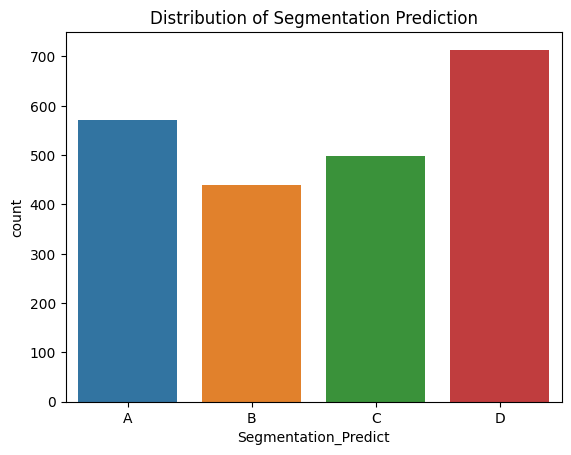

In [60]:
# Distribution of Segmentation Prediction

sns.countplot(data=test_predicted, 
              x = 'Segmentation_Predict', 
              hue='Segmentation_Predict', 
              order=['A', 'B', 'C', 'D'], 
              hue_order=['A', 'B', 'C', 'D'])
plt.title('Distribution of Segmentation Prediction')
plt.show()

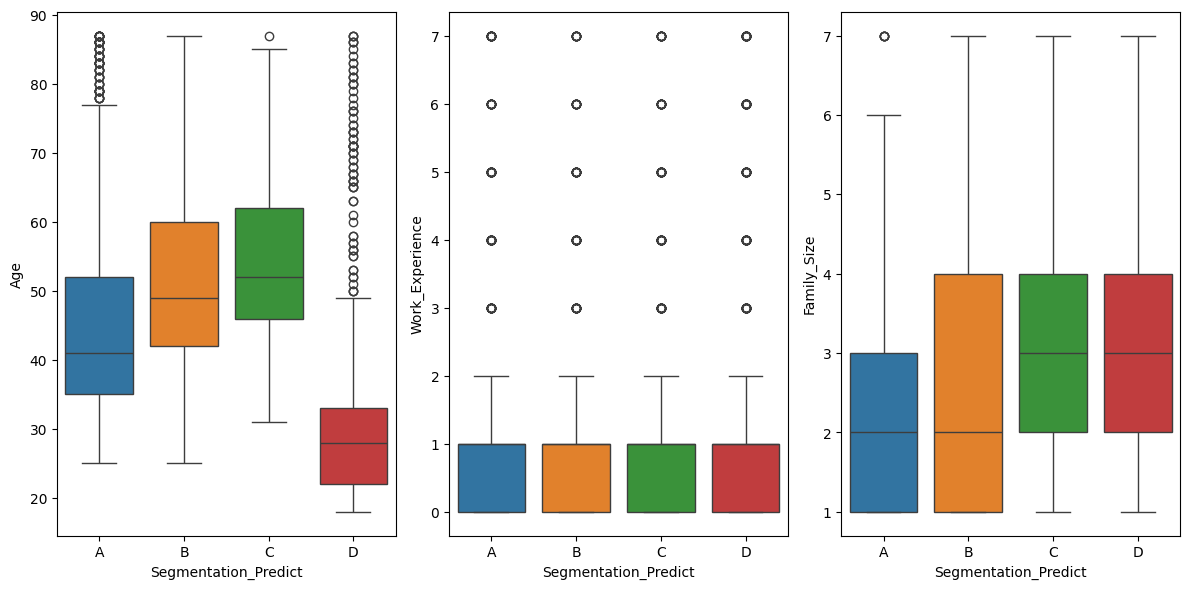

In [61]:
# Examining numerical features against customer segmentation prediction

num_cols = ['Age', 'Work_Experience', 'Family_Size']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
k = 0

for i in range(3):
    sns.boxplot(data=test_predicted, 
                x = 'Segmentation_Predict', 
                y = num_cols[k], 
                hue='Segmentation_Predict', 
                ax = axes[i],
                order=['A', 'B', 'C', 'D'],
                hue_order=['A', 'B', 'C', 'D'])
    k += 1

plt.tight_layout()
plt.show()

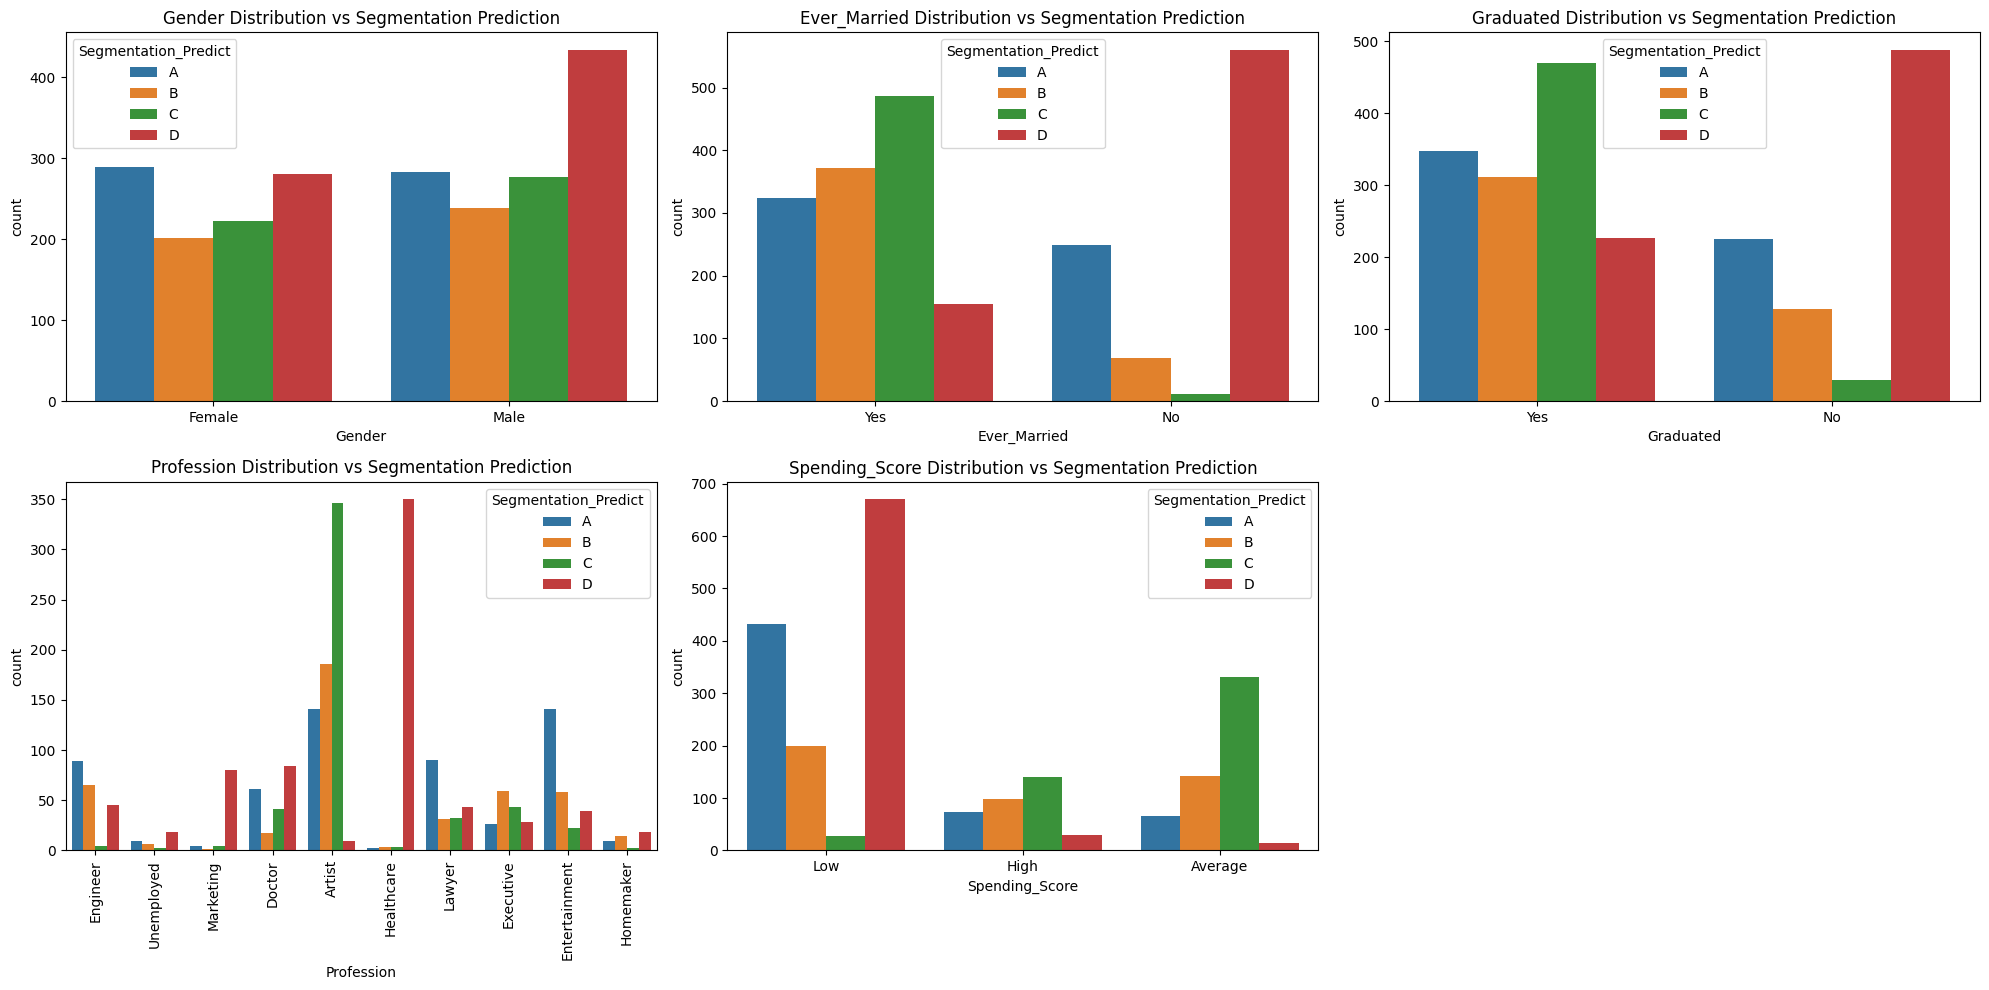

In [63]:
# Examining categorical features against customer segmentation prediction

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
k = 0
cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Segmentation_Predict']

for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            axes[i,j].axis('off')
            break
        sns.countplot(data=test_predicted, 
                      x = cat_cols[k], 
                      ax=axes[i,j], 
                      hue='Segmentation_Predict',
                      hue_order=['A', 'B', 'C', 'D'])
        axes[i,j].set_title(cat_cols[k] + ' Distribution vs Segmentation Prediction')
        k += 1

axes[1, 0].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


**Observations:**

- As with the training data, similar outcomes can be said in regards to the predicted customer segments in regards to the categorical variables.

## Conclusion

The customer segmentation analysis successfuly classified new potential customers into segments (A, B, C, D) using the CatBoost model as the best performing classifier. The trained model achieved an accuracy of **54.21%**, which, while modest, is indicative of the complexity of the segmentation task and the need for further improvements. Predictions for the test dataset have been generated, providing actionable segmentation labels for business use.

### Key Insights:

- CatBoost outperformed other models such as Logistic Regression, Decision Tree, Random Forest, SVM, and KNN in accuracy.

- The predicted segments for the new customers show a relatively balanced distribution, aligning with the training data, with customer segmentation slightly skewed towards the D segment.

### Recommendations for Improvement:

- Incorporate additional features such as geographical data, online behaviour metrics or loyalty program participation to enhance predictive accuracy.